# TP2 Deep Learning - CNN

Cette troisième séance porte sur la découverte des réseaux de convolutions :
* Retour sur MNIST
* Première architecture convolutionnelle
* Visualisation des filtres
* Utilisation de VGG16, un réseau pré-entrainé
* Visualisation des filtres par maximisation des activations
* Augmentation de données
* Classification du jeu de données Cifar10



In [1]:
"""
# A modifier !! Utile seulement sur le serveur de Luminy
venv_root = '/amuhome/ayache/deep'

import sys
sys.path.append(venv_root+'/lib/python3.5/site-packages')

import warnings
warnings.simplefilter("ignore")
"""

'\n# A modifier !! Utile seulement sur le serveur de Luminy\nvenv_root = \'/amuhome/ayache/deep\'\n\nimport sys\nsys.path.append(venv_root+\'/lib/python3.5/site-packages\')\n\nimport warnings\nwarnings.simplefilter("ignore")\n'

## Import des premiers packages nécessaires :

In [2]:
try:
    # core libraries
    %tensorflow_version 2.x
    import numpy as np
    import tensorflow as tf
    from tensorflow.keras.layers import *

    # plot libraries
    import matplotlib.pyplot as plt
    from google.colab.patches import cv2_imshow
except Exception:
    print('Tensorflow version 2 not available')

TensorFlow 2.x selected.


In [0]:
n_classes = 10
img_rows, img_cols, img_channels = 28, 28, 1

batch_size = 128
n_epochs = 20
validation_split = 0.1

## Chargement des données

Ici on charge le jeu de données MNIST (les chiffres manuscrits), puis quelques instructions de mise en forme

In [0]:
def get_data_mnist(n_classes, img_rows, img_cols, img_channels):
	##### Chargement des donnees MNIST

	# the data, shuffled and split between train and test sets
	(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

	# On transforme les entrée en les vectorisant et on les normalise simplement
	# (on sait que les pixels ont des valeurs entre 0 et 255)
	x_train = x_train.astype('float32') / 255.
	x_test = x_test.astype('float32') / 255.

	# redimensionnement des images pour les injecter dans le réseau
	x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, img_channels)
	x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, img_channels)

	# mettre les labels sous forme discrète
	y_train = tf.keras.utils.to_categorical(y_train, n_classes)
	y_test = tf.keras.utils.to_categorical(y_test, n_classes)

	return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = get_data_mnist(
    n_classes, img_rows, img_cols, img_channels
)

Le jeu de données MNIST contient 60000 exemples répartis en 10 classes. Nous allons ici en sélectionner aléatoirement un certain nombre pour accélérer les étapes suivantes.

In [0]:
n_train_samples = 5000

l_idx = list(range(x_train.shape[0]))
np.random.shuffle(l_idx) 
l_idx = l_idx[:n_train_samples]
x_train, y_train = x_train[l_idx], y_train[l_idx]

## Réseau dense

Reprenons le réseau considéré à la fin du premier TP. Notez son nombre de paramètres et sa performance obtenue, ils nous serviront de référence.

In [6]:
def create_dnn(input_shape=(28, 28, 1), num_classes=10):
    model = tf.keras.Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    # on compile avec un optimiseur adam et une loss multi-catégories
    model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

model_1 = create_dnn()
model_1.summary()

history_1 = model_1.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=n_epochs,
                        validation_split=validation_split,
                        callbacks=[],
                        verbose=1)

score_1 = model_1.evaluate(x_test, y_test, verbose=0)

print(f'[DNN MODEL 1] {score_1}')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                10250     
Total params: 937,482
Trainable params: 937,482
Non-trainable params: 0
__________________________________________________

## Architecture convolutionnelle

Créons un nouveau réseau dont les couches Dense (sauf la dernière pour la classification) sont remplacées par des Conv2D, suivies de MaxPooling2D. Notons que la couche "Flatten" n'est pas utilisée en début de réseau, puisque les données du réseau sont supposées 2D. En revanche, la couche Dense en bout de réseau suppose des données d'entrée en 1D.


In [7]:
def create_cnn(input_shape=(28, 28, 1), n_classes=10):
    """
    :param input_shape: Taille de l'image en entrée
    :param n_classes: Nombre de classes à prédire
    :return: Un modèle Sequential de tf.keras
    """
    model = tf.keras.Sequential()
    # block 1
    model.add(Conv2D(64, kernel_size=(5, 5),
                     strides=(1, 1), padding='same',
                     activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    # block 2
    model.add(Conv2D(128, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # block 3
    model.add(Conv2D(128, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # block classification
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

model_2 = create_cnn()
model_2.summary()

history_2 = model_2.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=n_epochs,
                        validation_split=validation_split,
                        callbacks=[],
                        verbose=1)

score_2 = model_2.evaluate(x_test, y_test, verbose=0)

print(f'[CNN MODEL 2] {score_2}')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

**Expliquez le nombre de paramètres de chaque couche**

* 

* 

### Visualisation des cartes

Une carte "réponse" (ou feature map) d'une couche de convolution correspond à l'état des activations en sortie d'une telle couche. Leur contenu dépend donc d'une image passée en entrée du réseau. 

Une couche définie pour apprendre 64 filtres de convolution, génère ainsi 64 cartes. On définie d'abord une fonction pour l'affichage d'un tableau d'images (via matplotlib)

In [0]:
def show_images(images, cols=1):
    n_images = len(images)
    fig = plt.figure()

    for idx, image in enumerate(images):
        # add a column
        fig.add_subplot(cols, np.ceil(n_images/float(cols)), idx+1)
        plt.axis('off')

        # black and white image
        if image.ndim == 2:
            plt.gray()

        plt.imshow(image)

Une manière simple pour obtenir ces cartes, via l'API Keras, consiste à faire passer une image (au choix mais de la bonne taille) à travers un réseau tronqué à la couche dont on veut visualiser les sorties.

0.0 0.89045644 (1, 28, 28, 64)


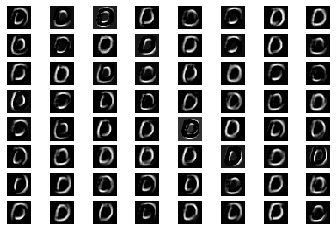

In [16]:
# DÃ©finition d'un modÃ¨le via la "graph" API de Keras
model_tmp = tf.keras.Model(model_2.layers[0].input,
                           model_2.layers[0].output)

# Cartes rÃ©ponses de x_test[10] (un '0')
feature_maps = model_tmp.predict(np.expand_dims(x_test[10], 0))

# normalisation des valeurs entre 0 et 1
minimum, maximum = np.min(feature_maps), np.max(feature_maps)
feature_maps = (feature_maps - minimum) / (maximum - minimum)

print(minimum, maximum, feature_maps.shape)

images = []
for i in range(64):
  images.append(np.array(255*feature_maps[:,:,:,i]).reshape(28, 28).astype('uint8'))

show_images(images, 8)

Les images obtenues semblent montrer que les filtres appris dans la premiÃ¨re couche du rÃ©seau permettent la dÃ©tection d'orientations ou des contours. 



<h4>Visualisation des filtres</h4>

La visualisation des filtres de la couche d'entrÃ©e est relativement immÃ©diate puisque que les filtres ont le mÃªme nombre de channels que les donnÃ©es d'entrÃ©e. Autrement dit, les filtres de la premiÃ¨re couche sont dÃ©finis sur le mÃªme domaine que les donnÃ©es.


In [10]:
# RÃ©cupÃ¨re tous les paramÃ¨tres appris par le rÃ©seau
weights = model_2.get_weights()
for w in weights: print(w.shape)

(5, 5, 1, 64)
(64,)
(3, 3, 64, 128)
(128,)
(3, 3, 128, 128)
(128,)
(1152, 10)
(10,)


<b>A faire : </b> A quoi correspondent chaque ligne issues de l'affichage de la cellule prÃ©cÃ©dente ?

Affichons maintenant les filtres de la premiÃ¨re couche de convolution :

-0.22860728 0.14895889


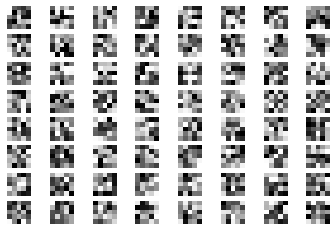

In [11]:
# normalize values between 0 and 1
minimum, maximum = np.min(weights[0]), np.max(weights[0])
weights0 = (weights[0] - minimum) / (maximum - minimum)

print(minimum, maximum)
# entre 0 et 255 pour l'affichage
weights0 *= 255.

images = []
for i in range(64):
  images.append(np.array(255*weights0[:,:,:,i]).reshape(5,5).astype('uint8'))

show_images(images, 8)

<h3> CNN pour des images naturelles </h3>

Les filtres de convolutions appris sur les donnÃ©es MNIST ne sont pas trÃ¨s parlantes, intÃ©ressons nous plutÃ´t Ã  un rÃ©seau (beaucoup plus profond) adaptÃ© Ã  la classification d'images naturelles. Nous allons considÃ©rer pour cela le rÃ©seau VGG16, prÃ©-entrainÃ© sur le dataset ImageNet (cf cours).

In [0]:
!wget https://pageperso.lis-lab.fr/stephane.ayache/cat.jpg
!wget https://pageperso.lis-lab.fr/stephane.ayache/imagenet_class_index.json 

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import json

# RÃ©cupÃ©ration du modÃ¨le complet VGG16
model3 = VGG16(include_top=True, weights='imagenet')
#print(model3.summary())

# chargement d'un dictionnaire qui met en correspondant l'index d'une classe ImageNet et son nom
with open('imagenet_class_index.json') as f:
    CLASS_INDEX = json.load(f)

# chargement et preprocess de l'image (dont normalisation et redimensionnement)
img_path = 'cat.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# prÃ©diction et affichage de la classe de probabilitÃ© maximale
softmax_output = model3.predict(x)
best_class = np.argmax(softmax_output)
im_class = CLASS_INDEX[str(best_class)][1]
print("prediction: ", im_class)

Notre chaton a Ã©tÃ© reconnu comme un chat ? Alors tout va bien, et regardons les filtres de la premiÃ¨re couche ...

In [0]:
weights = model3.get_weights()
#for w in weights: print(w.shape)
  
# normalize values between 0 and 1
minimum, maximum = np.min(weights[0]), np.max(weights[0])
weights0 = (weights[0] - minimum) / (maximum - minimum)

print(minimum, maximum)
# entre 0 et 255 pour l'affichage
weights0 *= 255.

images = []
for i in range(64):
  images.append(np.array(255*weights0[:,:,:,i]).reshape(3,3,3).astype('uint8'))

show_images(images, 8)

Notez qu'on affiche ici les fltres en RGB alors qu'on pourrait les afficher en sÃ©parant les channels. Dans tous les cas, cette visualisation reste peu informative, pour mieux comprendre le rÃ´le d'une couche de convolution, d'autres mÃ©thodes sont plus efficaces (cf cours prÃ©cÃ©dent). Ci dessous, nous allons gÃ©nÃ©rer une image qui maximise la valeur d'une carte d'activation (rÃ©ponse Ã  un filtre).

<h3> Visualisation par maximisation d'activations</h3>
  
Les fonctions Tensorflow du backend Keras nous permettent de dÃ©finir une fonction d'une image vers les activations d'une carte d'une couche de convolution. Maximiser cette fonction en suivant le gradient de la sortie par rapport aux entrÃ©es, revient Ã  dÃ©terminer une image (artificielle) dont VGG16 obtient une forte rÃ©ponse Ã  la convolution du filtre ciblÃ©. L'image produite va Ãªtre composÃ©e du "pattern" reconnu par le filtre...

D'abord, quelques fonctions utiles :

In [0]:
def deprocess_image(x):
# normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)
    
    return x * 255.

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())
  

print(model3.summary())


DÃ©finition d'une fonction en Keras ; obtention du gradient ; gradient ascent pour maximiser ; 

In [0]:
from keras import backend as K

num_filter = 208

# entrÃ©e de la fonction Ã  maximiser = entrÃ©e du rÃ©seau VGG = une image
input_img = model3.layers[0].input

# sortie = Somme (moyenne) des activations d'une carte de convolution associÃ©e au filtre num_filter
output = K.mean(model3.layers[17].output[:, :, :, num_filter])

# returns the gradients of output w.r.t. input
grads = K.gradients(output, input_img)[0]
grads = normalize(grads)

# fonction : input -> output, gradients 
func = K.function([input_img], [output, grads])

## gradient ascent ##

# point de dÃ©part alÃ©atoire
x = np.random.random((1, 224, 224, 3)) * 255.
x = preprocess_input(x)

for i in range(40): # 40 iterations
    loss_value, grads_value = func([x])
    x += grads_value * 10

    print('Current loss value:', loss_value)
    if loss_value <= 0.:
        # some filters get stuck to 0
        break

# point d'arrivÃ©e : conversion en RGB puis affichage
xx = deprocess_image(x)

from PIL import Image
print(xx.shape)
display(Image.fromarray(xx[0].astype('uint8')))


<b> A faire : </b> variez les couches et les filtres, puis commentez vos rÃ©sultats obtenus. Comment obtenir des motifs encore plus complexes ?

<h2> Entrainement d'un rÃ©seau trÃ¨s profond </h2>

Un rÃ©seau trÃ¨s profond tel que VGG contient Ã©normÃ©ment de paramÃ¨tres, son entrainement peu s'avÃ©rer compliquer. Tous les paramÃ¨tres doivent entrer en mÃ©moire (RAM ou GPU), ainsi que toutes les donnÃ©es d'un minibatch. Dans le cas d'images relativement volumineuses (ie: Imagenet =255x255x3), la taille du minibatch est souvent ainsi trÃ¨s couteux en mÃ©moire et se voit ainsi rÃ©duit Ã  quelques images, rendant l'entrainement encore plus long... 

Souvent, de grandes bases de donnÃ©es ne sont pas disponibles. Dans ce cas, pour parvenir Ã  entrainer un tel rÃ©seau avec peu d'images, plusieurs options sont possibles :
- partir d'un rÃ©seau dÃ©jÃ  (prÃ©-)entrainÃ©, et/ou utiliser ses poids pour initialiser un autre rÃ©seau qui sera appris sur une base (rÃ©duite) d'images (= finetuning, trÃ¨s efficace)
- rÃ©gulariser les poids du rÃ©seau (peut aider mais ne suffit pas)
- augmenter artificiellement le nombre de donnÃ©es (amÃ©liore toujours les performances d'un rÃ©seau)

Dans la suite, nous illustrons ce dernier point sur les donnÃ©es MNIST.


In [0]:

(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows, img_cols = 28, 28
num_classes = 10
nb_samples = len(x_train)
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# SÃ©lection alÃ©atoire de 5000 exemples
l_idx = list(range(nb_samples))
np.random.shuffle(l_idx) 
l_idx = l_idx[:5000]
x_train, y_train = x_train[l_idx], y_train[l_idx]

# conversion des Ã©tiquettes au format one-hot vector
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


# Architecture du modÃ¨le
model2 = Sequential()
model2.add(Conv2D(64, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', input_shape=input_shape))
model2.add(MaxPooling2D((2,2)))
model2.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model2.add(MaxPooling2D((2,2)))
model2.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model2.add(MaxPooling2D((2,2)))
model2.add(Flatten())
model2.add(Dropout(0.2))
model2.add(Dense(num_classes, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#print(model2.summary())

model2.fit(x_train, y_train, batch_size=128, epochs=20, verbose=1)

score = model2.evaluate(x_test, y_test, verbose=0)
print("score=", score)

La performance obtenue peut Ãªtre amÃ©liorÃ©e en augmentant les donnÃ©es. La cellule suivante gÃ©nÃ¨re 20000 donnÃ©es Ã  partir des 5000 utilisÃ©es jusque lÃ .



In [0]:
from keras.preprocessing.image import ImageDataGenerator

# dÃ©claration d'un gÃ©nÃ©rateur, qui transformera "Ã  la volÃ©e" des donnÃ©es MNIST 
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    zoom_range = 0.05, 
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=False, # flip horizontal et vertical n'ont pas de sens pour des digits !
    vertical_flip=False
    )
datagen.fit(x_train)

# On instancie le gÃ©nÃ©rateur
flow = datagen.flow(x_train, y_train, batch_size=128, shuffle=True)

# Pour affichage : une itÃ©ration du gÃ©nÃ©rateur
xx = next(flow)
print(xx[0].shape, xx[1].shape)

images = []
for i in range(64):
  images.append(np.array(255*xx[0][i,:,:,:]).reshape(28,28).astype('uint8'))
show_images(images, 8)


# rÃ©initialisation du modÃ¨le
model2 = Sequential()
model2.add(Conv2D(64, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', input_shape=input_shape))
model2.add(MaxPooling2D((2,2)))
model2.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model2.add(MaxPooling2D((2,2)))
model2.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model2.add(MaxPooling2D((2,2)))
model2.add(Flatten())
model2.add(Dropout(0.2))
model2.add(Dense(num_classes, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# entrainement avec les donnÃ©es augmentÃ©es (Ã  la volÃ©e)
model2.fit_generator(datagen.flow(x_train, y_train, batch_size=128), steps_per_epoch=int(20000/128), epochs=20)

# Ã©valuation
score = model2.evaluate(x_test, y_test, verbose=0)
print("score=", score)


<b>A faire : </b> testez d'autres formes d'augmentation et d'autres quantitÃ©s pour constater l'impact sur la prÃ©cision du rÃ©seau.
<b>A faire : </b> modifiez l'architecture pour la classification d'images naturelles, en utilisant le jeu de donnÃ©es Cifar10.